# Deconvolution

This notebook will cover an example of the deconvolution step of the BayesTME pipeline, using our melanoma dataset as an example.

First download the dataset form https://www.dropbox.com/s/aha4mcdrq12myfi/ST_mel1_rep2_counts.tsv?dl=0 and save it in your current working directory.

It is in count matrix format so we will load it using the `SpatialExpressionDataset.read_count_mat` method:

In [1]:
from bayestme import data

import urllib.request

stdata = data.SpatialExpressionDataset.read_count_mat('../ST_mel1_rep2_counts.tsv')

Next we will apply our gene filtering criteria, selecting genes with the most spatial variation, that appear in less than 95% of spots, and that are not ribosomal.

In [2]:
from bayestme import gene_filtering

stddev_filtered = gene_filtering.select_top_genes_by_standard_deviation(
    stdata, n_gene=1000)

spot_threshold_filtered = gene_filtering.filter_genes_by_spot_threshold(
    stddev_filtered, spot_threshold=0.95)

stdata_filtered = gene_filtering.filter_ribosome_genes(spot_threshold_filtered)


In [3]:
print('{}/{} genes selected'.format(len(stdata_filtered.gene_names), len(stdata.gene_names)))

885/16148 genes selected


This particular sample is not suitable for bleeding correction because there are no marked non-tissue spots, which are necessary for learning the bleed basis functions.

We will assume that M-fold cross-validation has already been run to determine the number of cell types, and given us the value of 4 cell types and smoothing parameter lambda = 1000.

We will use these parameters to demonstrate the next step, which is deconvolution. Here in this notebook we will run a limited number of samples (100) and with limited burn in and thinning, for the sake of computational brevity. Normally these values would be higher.

In [6]:
from bayestme import deconvolution

best_lambda = 1000
best_n_components = 4

deconvolution_result = deconvolution.deconvolve(
        reads=stdata_filtered.reads,
        edges=stdata_filtered.edges,
        n_gene=1000,
        n_components=best_n_components,
        lam2=best_lambda,
        n_samples=100,
        n_burnin=100,
        n_thin=1,
        random_seed=999,
        bkg=False,
        lda=False)

After we finish sampling from the posterior distribution, we can plot our results using BayesTME built-in plotting functions:

In [5]:
from bayestme import deconvolution
from pathlib import Path
from IPython.display import Image

deconvolution_result = data.DeconvolutionResult.read_h5('bayestme_melanoma_deconvolution_result.h5ad')

Path("./deconvolution_plots").mkdir(exist_ok=True)

deconvolution.plot_deconvolution(
        stdata=stdata_filtered,
        deconvolution_result=deconvolution_result,
        output_dir='./deconvolution_plots',
        output_format='png',
        marker_gene_method=deconvolution.MarkerGeneMethod.TIGHT)

/Users/jquinn/opt/anaconda3/envs/bayes_tme2/lib/python3.9/site-packages/bayestme-0.1.0-py3.9.egg/bayestme/deconvolution.py:295: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


The cell number plots show the expected number of cells of each type in each spot:

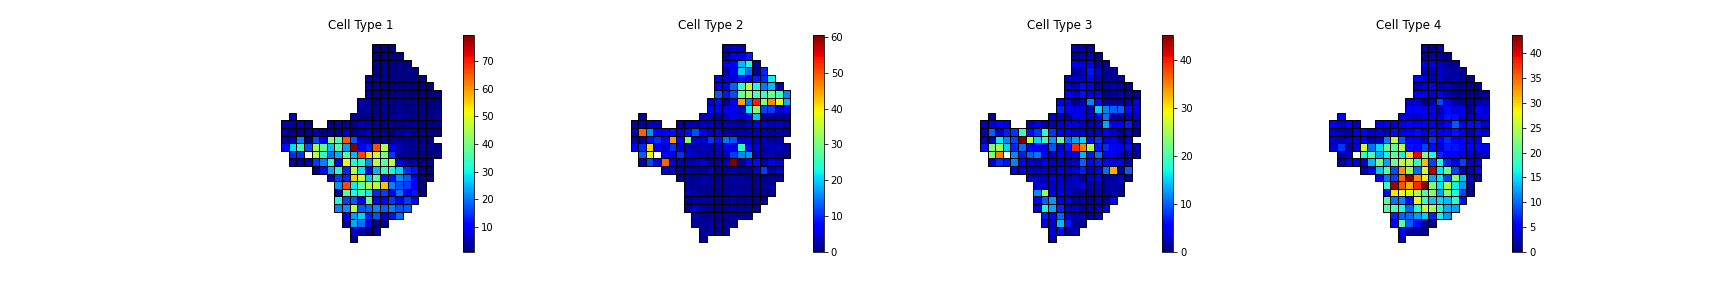

In [6]:
Image('./deconvolution_plots/cell_type_counts.png')

The cell probability plots show the probability of the cells in a given spot being a certain type:

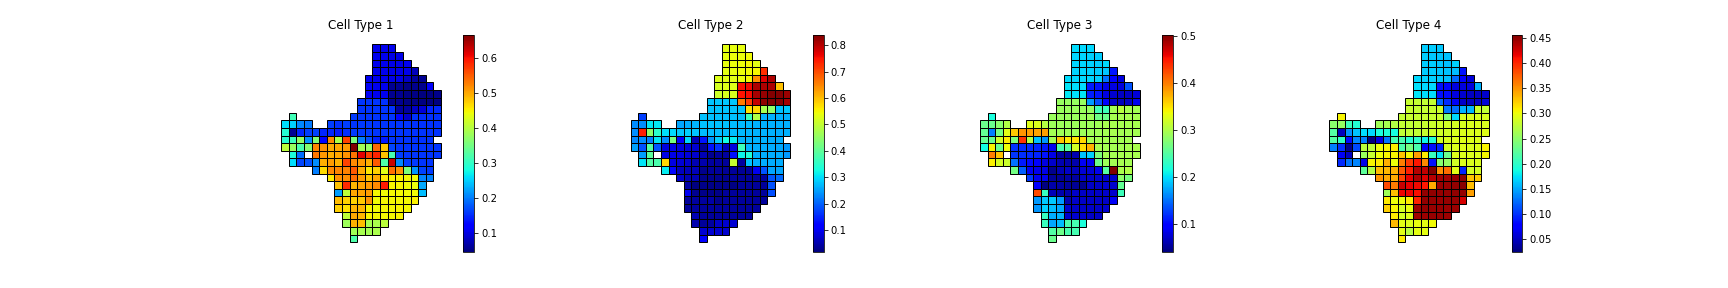

In [7]:
Image('./deconvolution_plots/cell_type_probabilities.png')

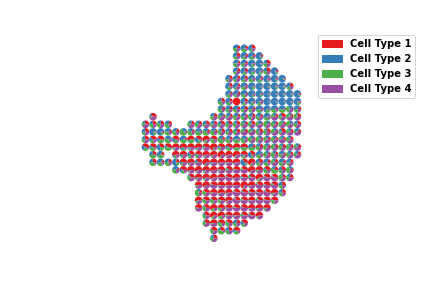

In [17]:
Image('./deconvolution_plots/cell_num_scatterpie.png')